In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Add project root to path
proj_root = Path.cwd().parent.parent
sys.path.insert(0, str(proj_root))

from dynamat.ontology import OntologyManager
from dynamat.mechanical.shpb.io import SpecimenLoader

# Import test ingestion tools
from dynamat.mechanical.shpb.io import (
    SHPBTestWriter,
    SHPBTestMetadata,
    CSVDataHandler
)

# Import SHPB analysis toolkit
from dynamat.mechanical.shpb import PulseDetector, PulseAligner, StressStrainCalculator, TukeyWindow

# Import ontology tools for RDF graph querying
from dynamat.ontology import OntologyManager

## Specimen Selection

In [2]:
# Create ontology manager
ontology_manager = OntologyManager()

# Create specimen loader
specimen_loader = SpecimenLoader(ontology_manager)

# Load specimen files from the specimens directory
files_loaded = specimen_loader.load_specimen_files()
print(f"Total specimen files loaded: {files_loaded}")

a356_specimens = specimen_loader.find_specimens(material_name="dyn:A356")

if a356_specimens:
    for specimen in a356_specimens:
        print(f"  - {specimen['id']}")
    print(f"\nTotal A356 specimens: {len(a356_specimens)}")
else:
    print("No A356 specimens found.")

# Store for next cell
specimens = a356_specimens

Total specimen files loaded: 3
  - DYNML-A356-00001
  - DYNML-A356-00002

Total A356 specimens: 2


In [3]:
# Select a specific specimen and load its detailed data
if specimens and len(specimens) > 0:
    # Select the first specimen for demonstration
    selected_specimen = specimens[0]
    
    specimen_id = selected_specimen['id']
    specimen_uri = selected_specimen['uri']
    
    print(f"Selected Specimen: {specimen_id}")
    
    # Get detailed specimen data with formatted printing
    specimen_data = specimen_loader.get_specimen_data(specimen_uri, print_data=False)
    
    # Store the specimen data for later use in SHPB analysis
    specimen_data = specimen_data
    SPECIMEN_URI = specimen_uri
    specimen_id = specimen_id
    
    print(f"\nSpecimen data stored in specimen_data variable")
    
else:
    print("No specimens available.")
    print("Please create specimens using the GUI first, then re-run this notebook.")
    specimen_data = None
    SPECIMEN_URI = None
    specimen_id = None

Selected Specimen: DYNML-A356-00001

Specimen data stored in specimen_data variable


## Raw Data Loading

In [4]:
# Load raw SHPB data from CSV file
csv_file_path = Path("A356_004.txt")  # UPDATE THIS PATH
raw_df = pd.read_csv(csv_file_path, sep="\t", header=1)                                      # DYN: This is user input in GUI
raw_df.rename(columns={"(ms)": "time", "(V)":"incident", "(V).1":"transmitted"}, inplace=True)

# Load the CSV
print(f"Loaded raw data from: {csv_file_path}")
print(f"DataFrame shape: {raw_df.shape}")
print(f"\nColumns: {list(raw_df.columns)}")
print(f"\nFirst few rows:")
print(raw_df.head())

# Validate the DataFrame structure
handler = CSVDataHandler(raw_df)
try:
    handler.validate_structure()
    print("\nDataFrame validation: PASSED")
except ValueError as e:
    print(f"\nDataFrame validation: FAILED")
    print(f"Error: {e}")

Loaded raw data from: A356_004.txt
DataFrame shape: (160004, 3)

Columns: ['time', 'incident', 'transmitted']

First few rows:
       time  incident  transmitted
0 -0.400024 -0.004883     0.001221
1 -0.400012 -0.004883     0.001221
2 -0.399999 -0.004883     0.001221
3 -0.399987 -0.004883     0.001221
4 -0.399974 -0.004883     0.001221

DataFrame validation: PASSED


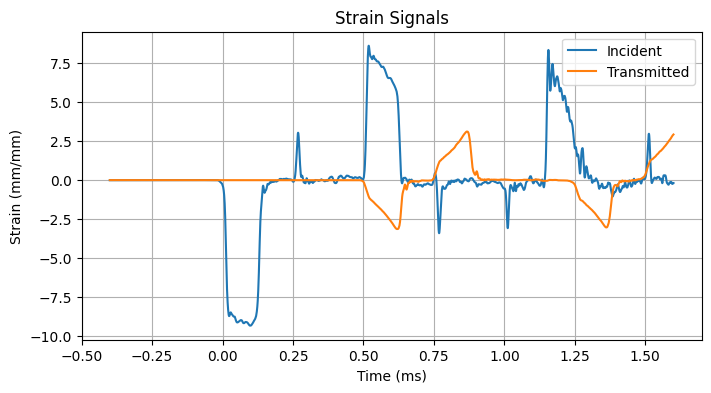

In [5]:
plt.figure(figsize=(8,4))
plt.plot(raw_df["time"], raw_df["incident"], label = "Incident")
plt.plot(raw_df["time"], raw_df["transmitted"], label = "Transmitted")
plt.title(f"Strain Signals")
plt.xlabel("Time (ms)")
plt.ylabel("Strain (mm/mm)")
plt.legend()
plt.grid()
plt.show()

## Equipment Metadata Extraction

In [6]:
# Create SHPB test metadata with equipment URIs
test_date = "2025-01-15"  # UPDATE THIS
test_id = f"{specimen_id}_SHPB_{test_date}"

print(f"Creating test metadata for: {test_id}")
print("=" * 60)

# Create minimal metadata object
test_metadata = SHPBTestMetadata(
    test_id=test_id,
    specimen_uri=SPECIMEN_URI,
    test_date=test_date,
    user="dyn:User_ErwinCazares",  # UPDATE THIS
    
    # Equipment URIs (from mechanical_testing_individuals.ttl)
    incident_bar_uri="dyn:IncidentBar_C350_8ft_0375in",
    transmission_bar_uri="dyn:TransmissionBar_C350_6ft_0375in",
    incident_strain_gauge_uri="dyn:StrainGauge_SHPB_001",
    transmission_strain_gauge_uri="dyn:StrainGauge_SHPB_002",

    #Optional
    striker_bar_uri="dyn:StrikerBar_C350_12in_0375in",
    striker_velocity = 10, # m/s
    momentum_trap_uri="dyn:MomentumTrap_TailoredGap", # or dyn:MomentumTrap_Full
    momentum_trap_distance = 3.0 # mm
)

# Validate metadata
try:
    test_metadata.validate()
    print("Metadata validation: PASSED")
except ValueError as e:
    print(f"Metadata validation: FAILED - {e}")

print(f"Test ID: {test_metadata.test_id}")
print(f"Specimen: {test_metadata.specimen_uri}")
print(f"Date: {test_metadata.test_date}")
print(f"User: {test_metadata.user}")


Creating test metadata for: DYNML-A356-00001_SHPB_2025-01-15
Metadata validation: PASSED
Test ID: DYNML-A356-00001_SHPB_2025-01-15
Specimen: https://dynamat.utep.edu/ontology#DYNML_A356_00001
Date: 2025-01-15
User: dyn:User_ErwinCazares


In [7]:
# Extract equipment properties from ontology
print("Extracting equipment properties from ontology...")
print("=" * 60)

# Extract all equipment properties in one call
equipment = test_metadata.extract_all_equipment_properties(specimen_loader)

# Display extracted properties
# Store critical values for SHPB analysis

# Bar material properties
bar_cross_section = equipment['incident_bar']['cross_section']  # mm2
bar_wave_speed = equipment['incident_bar']['wave_speed']  # m/s
bar_elastic_modulus = equipment['incident_bar']['elastic_modulus']
bar_density = equipment['incident_bar']['density']
striker_length = equipment["striker_bar"]["length"]
striker_velocity = test_metadata.striker_velocity

# Specimen properties
specimen_cross_section = specimen_data['dimensions']['hasFinalCrossSection']
specimen_length = specimen_data['dimensions']['hasFinalLength']

#Strain Gauge Factors
incident_reflected_gauge_params={
    'gauge_res': equipment["incident_gauge"]["gauge_resistance"],
    'gauge_factor': equipment["incident_gauge"]["gauge_factor"],
    'cal_voltage': equipment["incident_gauge"]["calibration_voltage"],
    'cal_resistance': equipment['incident_gauge']["calibration_resistance"]}

transmitted_gauge_params={
    'gauge_res': equipment["transmission_gauge"]["gauge_resistance"],
    'gauge_factor': equipment["transmission_gauge"]["gauge_factor"],
    'cal_voltage': equipment["transmission_gauge"]["calibration_voltage"],
    'cal_resistance': equipment["transmission_gauge"]["calibration_resistance"]
}


print(f"="*60)
print("Equipment properties extracted successfully!")
print("Ready for SHPB analysis with:")
print(f"  Bar cross-section: {bar_cross_section} mm2")
print(f"  Bar wave speed: {bar_wave_speed} m/s")
print(f"  Bar Elastic Modulus: {bar_elastic_modulus / 1000} GPa")
print(f"  Specimen cross-section: {specimen_cross_section} mm2")
print(f"  Specimen length: {specimen_length} mm")


Extracting equipment properties from ontology...
Equipment properties extracted successfully!
Ready for SHPB analysis with:
  Bar cross-section: 71.25574 mm2
  Bar wave speed: 5000.0 m/s
  Bar Elastic Modulus: 200.0 GPa
  Specimen cross-section: 0.11 mm2
  Specimen length: 0.1 mm


## Pulse Analysis Section

In [8]:
# Calculate pulse duration in data points
pulse_duration_ms = (2 * striker_length ) / bar_wave_speed          # duration (ms) = 2L / C_bar
pulse_length = 2 * striker_length
dt = np.median(np.diff(raw_df["time"]))  # sampling interval in ms
pulse_pts = int(pulse_duration_ms / dt)

print(f"Pulse duration: {pulse_duration_ms} ms")
print(f"Pulse length: {pulse_length} mm")
print(f"Sampling interval: {dt:.6f} ms")
print(f"Pulse points: {pulse_pts}")

# Pulse properties
pulse_stress_amplitude = (0.5 * bar_density * bar_wave_speed * striker_velocity ) / 1000
pulse_strain_amplitude = 0.5 * (striker_velocity / bar_wave_speed)

print(f"Pulse stress amplitude: {pulse_stress_amplitude:.2f} MPa")
print(f"Pulse strain amplitude: {pulse_strain_amplitude:.3e} mm/mm")

# Create detector with configuration
detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(5000, 2000, 1000),  # Try multiple thresholds               # DYN: GUI should allow k_trials if needed
    polarity="compressive",
    min_separation=int(0.8 * pulse_pts)
)

print(f"\nPulseDetector initialized:")
print(f"  Template polarity: {detector.polarity}")
print(f"  Min separation: {detector.min_separation} samples")

Pulse duration: 0.12192 ms
Pulse length: 609.6 mm
Sampling interval: 0.000012 ms
Pulse points: 9753
Pulse stress amplitude: 202.06 MPa
Pulse strain amplitude: 1.000e-03 mm/mm

PulseDetector initialized:
  Template polarity: compressive
  Min separation: 7802 samples


## Determine Pulse Windows

In [9]:
# Define search bounds to ignore noise regions
# These bounds should be adjusted based on your experimental setup
LB = 10000   # lower bound - start searching after this index                               # DYN: GUI should allow setting UB and LB if needed
UB = 115000  # upper bound - stop searching before this index

# Detect incident pulse
print("Detecting incident pulse...")
incident_window = detector.find_window(
    raw_df["incident"].values,
    lower_bound=LB,
    upper_bound=50000,  # Incident comes first
    metric="median",
    debug=True
)
print(f"Incident window: {incident_window}")

Detecting incident pulse...

[find_window] k_sigma = 5000
[matched] σ=9.42e-02 thr=4.71e+02 peaks=7233
  window: pk=32252 idx=(27376,37128) len=9752
  → 1 window(s)

[find_window] k_sigma = 2000
[matched] σ=9.42e-02 thr=1.88e+02 peaks=11816
  window: pk=29955 idx=(25079,34831) len=9752
  window: pk=37757 idx=(32881,42633) len=9752
  → 2 window(s)

[find_window] k_sigma = 1000
[matched] σ=9.42e-02 thr=9.42e+01 peaks=13534
  window: pk=29087 idx=(24211,33963) len=9752
  window: pk=36889 idx=(32013,41765) len=9752
  → 2 window(s)
[window] selected idx=(32881, 42633) median=8.9977e+00 (bounds [10000,50000])
Incident window: (32881, 42633)


In [10]:
# Detect transmitted pulse
print("\nDetecting transmitted pulse...")
# Create new detector with different thresholds for transmitted
transmitted_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(1500, 1000, 800),
    polarity="compressive"
)
transmitted_window = transmitted_detector.find_window(
    raw_df["transmitted"].values,
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=True
)
print(f"Transmitted window: {transmitted_window}")


Detecting transmitted pulse...

[find_window] k_sigma = 1500
[matched] σ=5.12e-02 thr=7.68e+01 peaks=19722
  window: pk=72138 idx=(67262,77014) len=9752
  window: pk=79940 idx=(75064,84816) len=9752
  window: pk=131729 idx=(126853,136605) len=9752
  window: pk=139531 idx=(134655,144407) len=9752
  → 4 window(s)

[find_window] k_sigma = 1000
[matched] σ=5.12e-02 thr=5.12e+01 peaks=23338
  window: pk=71033 idx=(66157,75909) len=9752
  window: pk=78835 idx=(73959,83711) len=9752
  window: pk=130582 idx=(125706,135458) len=9752
  window: pk=138384 idx=(133508,143260) len=9752
  → 4 window(s)

[find_window] k_sigma = 800
[matched] σ=5.12e-02 thr=4.09e+01 peaks=24894
  window: pk=70552 idx=(65676,75428) len=9752
  window: pk=78354 idx=(73478,83230) len=9752
  window: pk=130084 idx=(125208,134960) len=9752
  window: pk=137886 idx=(133010,142762) len=9752
  → 4 window(s)
[window] selected idx=(75064, 84816) median=2.0626e+00 (bounds [10000,115000])
Transmitted window: (75064, 84816)


In [11]:
# Detect reflected pulse (tensile, in incident signal)
print("\nDetecting reflected pulse...")
reflected_detector = PulseDetector(
    pulse_points=pulse_pts,
    k_trials=(2800, 1500, 1000, 500),
    polarity="tensile",  # Reflected is tensile
    min_separation=int(0.6 * pulse_pts)
)
reflected_window = reflected_detector.find_window(
    raw_df["incident"].values,  # Reflected is in incident channel
    lower_bound=LB,
    upper_bound=UB,
    metric="median",
    debug=True
)
print(f"Reflected window: {reflected_window}")


Detecting reflected pulse...

[find_window] k_sigma = 2800
[matched] σ=9.42e-02 thr=2.64e+02 peaks=15610
  window: pk=70574 idx=(65698,75450) len=9752
  window: pk=76425 idx=(71549,81301) len=9752
  window: pk=122232 idx=(117356,127108) len=9752
  window: pk=128083 idx=(123207,132959) len=9752
  → 4 window(s)

[find_window] k_sigma = 1500
[matched] σ=9.42e-02 thr=1.41e+02 peaks=21422
  window: pk=69411 idx=(64535,74287) len=9752
  window: pk=75262 idx=(70386,80138) len=9752
  window: pk=120918 idx=(116042,125794) len=9752
  window: pk=126769 idx=(121893,131645) len=9752
  → 4 window(s)

[find_window] k_sigma = 1000
[matched] σ=9.42e-02 thr=9.42e+01 peaks=23864
  window: pk=68903 idx=(64027,73779) len=9752
  window: pk=74754 idx=(69878,79630) len=9752
  window: pk=80605 idx=(75729,85481) len=9752
  window: pk=120408 idx=(115532,125284) len=9752
  window: pk=126259 idx=(121383,131135) len=9752
  → 5 window(s)

[find_window] k_sigma = 500
[matched] σ=9.42e-02 thr=4.71e+01 peaks=28628
  w

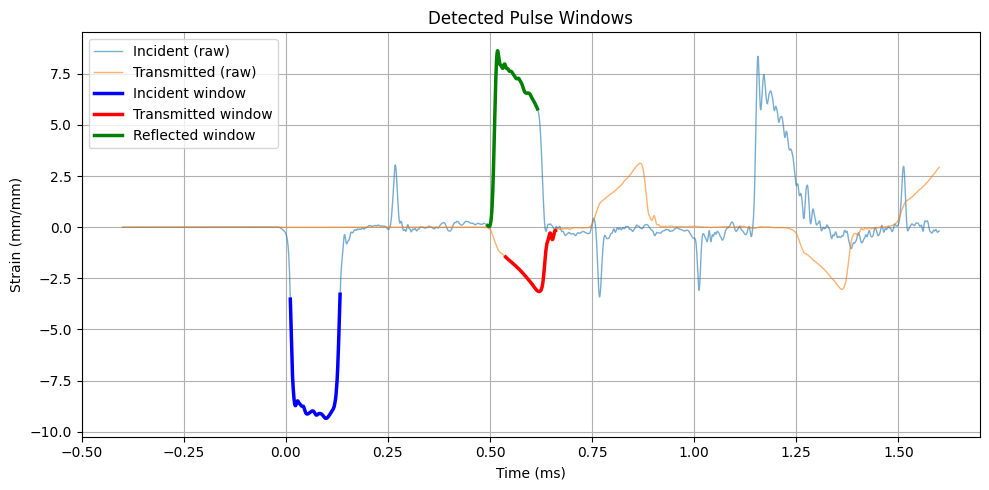

Window lengths:
  Incident: 9752 samples
  Transmitted: 9752 samples
  Reflected: 9752 samples


In [12]:
# Visualize detected windows
i0, i1 = incident_window
t0, t1 = transmitted_window
r0, r1 = reflected_window

fig, ax = plt.subplots(figsize=(10, 5))

# Full raw traces
ax.plot(raw_df["time"], raw_df["incident"], lw=1, alpha=0.6, label="Incident (raw)")
ax.plot(raw_df["time"], raw_df["transmitted"], lw=1, alpha=0.6, label="Transmitted (raw)")

# Highlight detected windows
ax.plot(raw_df["time"].iloc[i0:i1], raw_df["incident"].iloc[i0:i1],
        lw=2.5, label="Incident window", c="blue")
ax.plot(raw_df["time"].iloc[t0:t1], raw_df["transmitted"].iloc[t0:t1],
        lw=2.5, label="Transmitted window", c="red")
ax.plot(raw_df["time"].iloc[r0:r1], raw_df["incident"].iloc[r0:r1],
        lw=2.5, label="Reflected window", c="green")

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Strain (mm/mm)")
ax.set_title("Detected Pulse Windows")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

print(f"Window lengths:")
print(f"  Incident: {i1-i0} samples")
print(f"  Transmitted: {t1-t0} samples")
print(f"  Reflected: {r1-r0} samples")

## Center and Segment Pulses

[segment_and_center] shift = -30 points
[segment_and_center] shift = +481 points
[segment_and_center] shift = -488 points


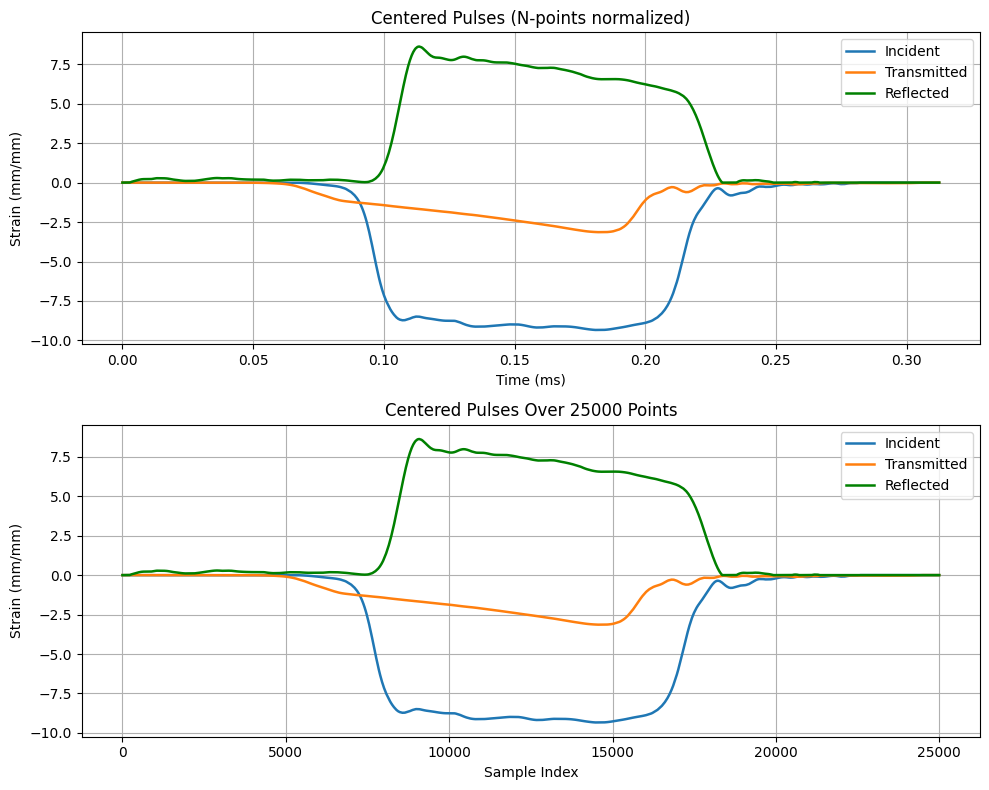


Segment shapes:
  Incident: (25000,)
  Transmitted: (25000,)
  Reflected: (25000,)


In [13]:
# Define number of points for centered segments
n_pts = 25000

# Segment and center incident pulse
inc_seg = detector.segment_and_center(
    raw_df["incident"].values,
    incident_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=0.0,  # Set to 0 to keep all data (no noise suppression)
    debug=True
)

# Segment and center transmitted pulse
trs_seg = transmitted_detector.segment_and_center(
    raw_df["transmitted"].values,
    transmitted_window,
    n_points=n_pts,
    polarity="compressive",
    thresh_ratio=0.0,
    debug=True
)

# Segment and center reflected pulse
ref_seg = reflected_detector.segment_and_center(
    raw_df["incident"].values,  # Reflected is in incident channel
    reflected_window,
    n_points=n_pts,
    polarity="tensile",
    thresh_ratio=0.0,
    debug=True
)

# Visualize centered pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Time axis for centered pulses
time_seg = np.arange(n_pts) * dt

# Plot 1: Centered pulses vs time
ax1.plot(time_seg, inc_seg, label="Incident", lw=1.8)
ax1.plot(time_seg, trs_seg, label="Transmitted", lw=1.8)
ax1.plot(time_seg, ref_seg, label="Reflected", lw=1.8, c="green")
ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Strain (mm/mm)")
ax1.set_title("Centered Pulses (N-points normalized)")
ax1.legend()
ax1.grid()

# Plot 2: Centered pulses vs sample index
ax2.plot(inc_seg, label="Incident", lw=1.8)
ax2.plot(trs_seg, label="Transmitted", lw=1.8)
ax2.plot(ref_seg, label="Reflected", lw=1.8, c="green")
ax2.set_xlabel("Sample Index")
ax2.set_ylabel("Strain (mm/mm)")
ax2.set_title(f"Centered Pulses Over {n_pts} Points")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

print(f"\nSegment shapes:")
print(f"  Incident: {inc_seg.shape}")
print(f"  Transmitted: {trs_seg.shape}")
print(f"  Reflected: {ref_seg.shape}")

## Align Pulse Fronts

In [14]:
# Optimization weights for fitness function
# These control the relative importance of each equilibrium criterion
opt_weights = {
    'corr': 0.3,   # Pulse correlation
    'u': 0.3,      # Bar displacement equilibrium
    'sr': 0.3,     # Strain rate equilibrium
    'e': 0.1       # Strain equilibrium
}

In [15]:
# Create PulseAligner instance
aligner = PulseAligner(
    bar_wave_speed=bar_wave_speed,
    specimen_length=specimen_length,
    k_linear=0.35,  # Use 35% of steepest slope to define linear region
    weights=opt_weights
)

# Define search bounds for optimization
# These constrain where the algorithm looks for optimal shifts
# Adjust based on your experimental setup and expected pulse timing
search_bounds_t = (1300, 1500)    # Transmitted shift bounds (samples)
search_bounds_r = (-600, -100)  # Reflected shift bounds (samples)

print(f"PulseAligner initialized:")
print(f"  k_linear: {aligner.k_linear}")
print(f"  Search bounds transmitted: {search_bounds_t}")
print(f"  Search bounds reflected: {search_bounds_r}")

# Run alignment optimization
print(f"\nRunning alignment optimization...")
inc_aligned, trs_aligned, ref_aligned, shift_t, shift_r = aligner.align(
    incident=inc_seg,
    transmitted=trs_seg,
    reflected=ref_seg,
    time_vector=time_seg,
    search_bounds_t=search_bounds_t,
    search_bounds_r=search_bounds_r,
    debug=True  # Set to False to suppress optimization output
)

print(f"\n{'='*60}")
print(f"Alignment complete!")
print(f"  Transmitted shift: {shift_t:+d} samples")
print(f"  Reflected shift: {shift_r:+d} samples")
print(f"{'='*60}")

PulseAligner initialized:
  k_linear: 0.35
  Search bounds transmitted: (1300, 1500)
  Search bounds reflected: (-600, -100)

Running alignment optimization...
[PulseAligner] Linear region: [7234, 8194] (960 points)
[PulseAligner] Search bounds: T=(1300, 1500), R=(-600, -100)
differential_evolution step 1: f(x)= -0.2975777999718445
differential_evolution step 2: f(x)= -0.2976918340490877
differential_evolution step 3: f(x)= -0.2976918340490877
differential_evolution step 4: f(x)= -0.2976918340490877
differential_evolution step 5: f(x)= -0.29769213380784026
differential_evolution step 6: f(x)= -0.29769213380784026
differential_evolution step 7: f(x)= -0.2977470702733453
differential_evolution step 8: f(x)= -0.2977470702733453
differential_evolution step 9: f(x)= -0.2977470702733453
differential_evolution step 10: f(x)= -0.2977470702733453
differential_evolution step 11: f(x)= -0.2977470702733453
differential_evolution step 12: f(x)= -0.2977470702733453
differential_evolution step 13: f(

In [16]:
# Build time axis centered on incident pulse rise
# Find the rise front (8% threshold of max amplitude)
front_thresh = 0.08
inc_abs = np.abs(inc_aligned)
front_idx = np.argmax(inc_abs > front_thresh * inc_abs.max())

# Create time axis with t=0 at the rise front
time_aligned = (np.arange(n_pts) - front_idx) * dt

print(f"Time axis centered on incident rise:")
print(f"  Rise front index: {front_idx}")
print(f"  Time range: [{time_aligned[0]:.3f}, {time_aligned[-1]:.3f}] ms")
print(f"  Zero crossing at sample {front_idx}")

Time axis centered on incident rise:
  Rise front index: 7079
  Time range: [-0.088, 0.224] ms
  Zero crossing at sample 7079


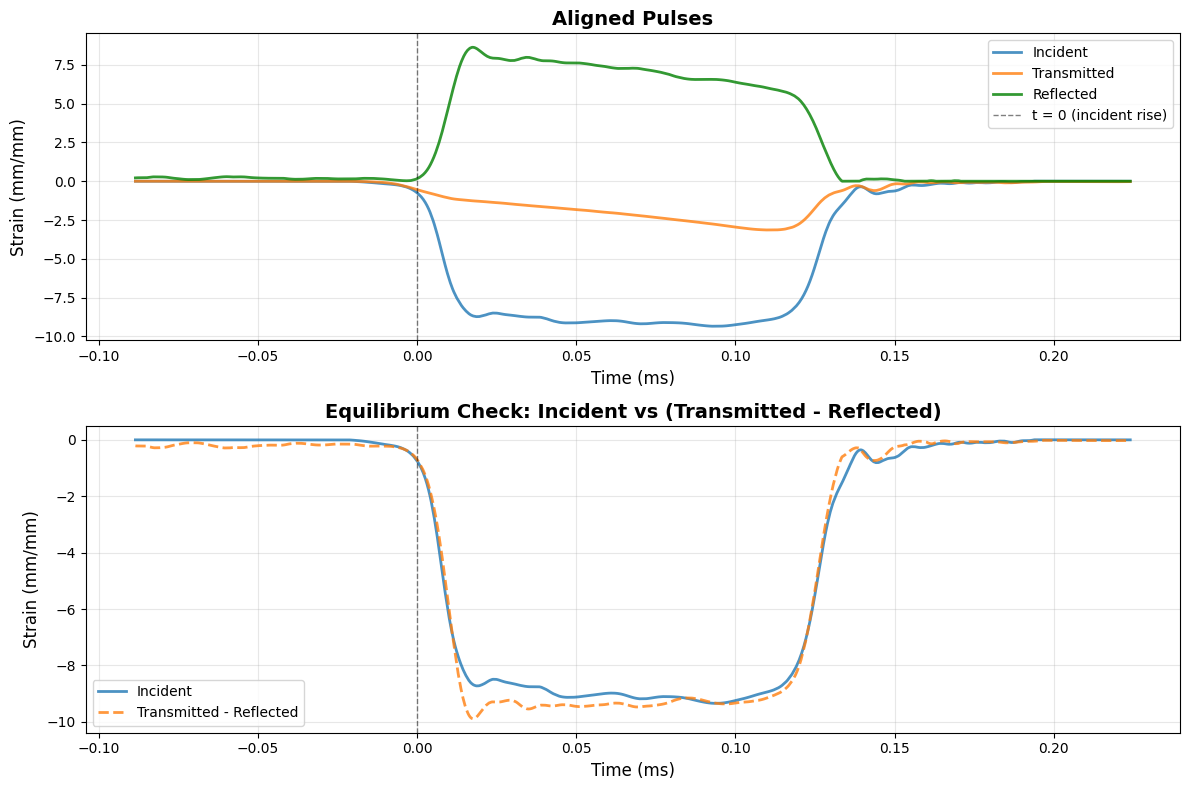


Equilibrium correlation:
  Pearson r = 0.9977 (p-value: 0.00e+00)


In [17]:
# Visualize aligned pulses
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Aligned pulses
ax1.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax1.plot(time_aligned, trs_aligned, lw=2.0, label="Transmitted", alpha=0.8)
ax1.plot(time_aligned, ref_aligned, lw=2.0, label="Reflected", c="green", alpha=0.8)
ax1.axvline(0, ls="--", c="k", lw=1, alpha=0.5, label="t = 0 (incident rise)")
ax1.set_xlabel("Time (ms)", fontsize=12)
ax1.set_ylabel("Strain (mm/mm)", fontsize=12)
ax1.set_title("Aligned Pulses", fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Plot 2: Check equilibrium (incident vs transmitted - reflected)
equilibrium_check = trs_aligned - ref_aligned
ax2.plot(time_aligned, inc_aligned, lw=2.0, label="Incident", alpha=0.8)
ax2.plot(time_aligned, equilibrium_check, lw=2.0, label="Transmitted - Reflected",
         alpha=0.8, ls='--')
ax2.axvline(0, ls="--", c="k", lw=1, alpha=0.5)
ax2.set_xlabel("Time (ms)", fontsize=12)
ax2.set_ylabel("Strain (mm/mm)", fontsize=12)
ax2.set_title("Equilibrium Check: Incident vs (Transmitted - Reflected)",
              fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display correlation coefficient
from scipy.stats import pearsonr
# Use only the region where both signals are non-zero
mask = (np.abs(inc_aligned) > 1e-6) & (np.abs(equilibrium_check) > 1e-6)
if mask.sum() > 0:
    corr, pval = pearsonr(inc_aligned[mask], equilibrium_check[mask])
    print(f"\nEquilibrium correlation:")
    print(f"  Pearson r = {corr:.4f} (p-value: {pval:.2e})")

## Calculate Stress-Strain Curves

In [19]:
# Strain scale factor for converting gauge output to dimensionless strain
# Default is 1e4 (assumes gauge output where 10000 = 1.0 strain)
strain_scale_factor = 1

# Create StressStrainCalculator instance with strain scale factor
calculator = StressStrainCalculator(
    bar_area=bar_cross_section,
    bar_wave_speed=bar_wave_speed,
    bar_elastic_modulus=bar_elastic_modulus,
    specimen_area=specimen_cross_section,
    specimen_length=specimen_length,
    strain_scale_factor=strain_scale_factor,
    use_voltage_input=True,
    incident_reflected_gauge_params = incident_reflected_gauge_params,
    transmitted_gauge_params = transmitted_gauge_params
)

print(f"\nStressStrainCalculator initialized:")
print(f"  Area ratio: {calculator.area_ratio:.3f}")


StressStrainCalculator initialized:
  Area ratio: 647.779


In [32]:
# Calculate stress-strain curves using all three methods
all_results = calculator.calculate(
    incident=inc_aligned,
    transmitted=trs_aligned,
    reflected=ref_aligned,
    time_vector=time_aligned
)

# Extract results for each method
time = all_results['time']
stress_1w = all_results["stress_1w"]
true_stress_1w = all_results["true_stress_1w"]
strain_1w = all_results["strain_1w"]
true_strain_1w = all_results["true_strain_1w"]
strain_rate_1w = all_results["strain_rate_1w"]
true_strain_rate_1w = all_results["true_strain_rate_1w"]

stress_3w = all_results["stress_3w"]
true_stress_3w = all_results["true_stress_3w"]
strain_3w = all_results["strain_3w"]
true_strain_3w = all_results["true_strain_3w"]
strain_rate_3w = all_results["strain_rate_3w"]
true_strain_rate_3w = all_results["true_strain_rate_3w"]

# Caculate Rise time
inc_rise_time = detector.calculate_rise_time(inc_aligned, time_aligned)


print("Stress-strain calculation complete!")
print(f"\nData shapes (all methods):")
print(f"  Time: {time.shape}")
print(f"  Stress: {stress_1w.shape}")
print(f"  Strain: {strain_1w.shape}")
print(f"  Strain rate: {strain_rate_1w.shape}")

print(f"\nPeak values (1-wave method):")
print(f"  Max stress: {stress_1w.max():.2f} MPa")
print(f"  Max strain: {stress_1w.max():.4f}")
print(f"  Max strain rate: {strain_rate_1w.max():.2f} 1/s")
print(f"  Inc Rise Time: {inc_rise_time:.4f} ms")

Stress-strain calculation complete!

Data shapes (all methods):
  Time: (25000,)
  Stress: (25000,)
  Strain: (25000,)
  Strain rate: (25000,)

Peak values (1-wave method):
  Max stress: 197518.70 MPa
  Max strain: 197518.7050
  Max strain rate: 418276.14 1/s
  Inc Rise Time: 0.0127 ms


D:\DynaMat-Platform\dynamat\mechanical\shpb\core\stress_strain.py:285: RuntimeWarning: invalid value encountered in log
  true_strain_rate_3w = np.log(1 - strain_rate_3w)
D:\DynaMat-Platform\dynamat\mechanical\shpb\core\stress_strain.py:298: RuntimeWarning: invalid value encountered in log
  true_strain_3w = np.log(1 + strain_3w)


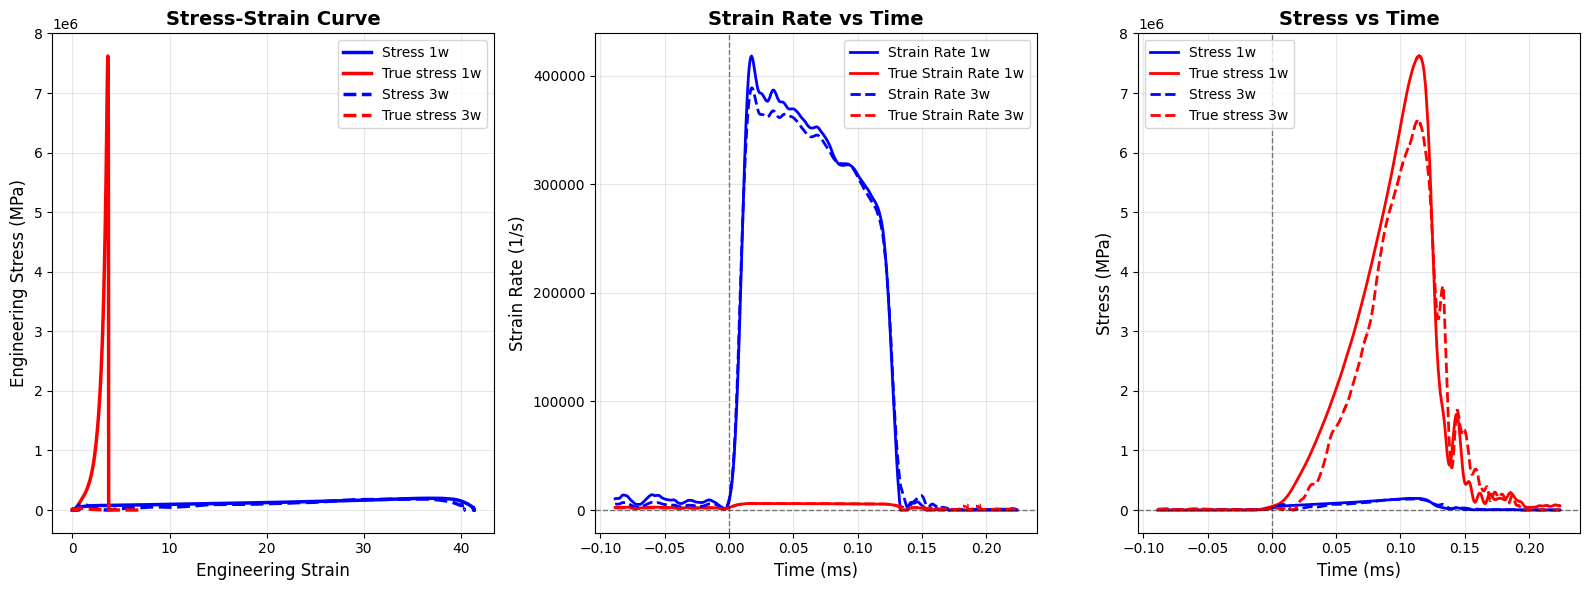

In [21]:
# Visualize stress-strain curve
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Plot 1: Stress-Strain curve (1-wave method)
ax1.plot(strain_1w, stress_1w, lw=2.5, color='blue', label='Stress 1w')
ax1.plot(true_strain_1w, true_stress_1w, lw=2.5, color='red', label='True stress 1w')
ax1.plot(strain_3w, stress_3w, lw=2.5, ls="--", color='blue', label='Stress 3w')
ax1.plot(true_strain_3w, true_stress_3w, lw=2.5, ls="--", color='red', label='True stress 3w')
ax1.set_xlabel('Engineering Strain', fontsize=12)
ax1.set_ylabel('Engineering Stress (MPa)', fontsize=12)
ax1.set_title('Stress-Strain Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Strain rate vs time
ax2.plot(time, strain_rate_1w, lw=2.0, color='blue', label='Strain Rate 1w')
ax2.plot(time, true_strain_rate_1w, lw=2.0, color='red', label='True Strain Rate 1w')
ax2.plot(time, strain_rate_3w, lw=2.0, ls="--", color='blue', label='Strain Rate 3w')
ax2.plot(time, true_strain_rate_3w, lw=2.0, ls="--", color='red', label='True Strain Rate 3w')
ax2.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax2.set_xlabel('Time (ms)', fontsize=12)
ax2.set_ylabel('Strain Rate (1/s)', fontsize=12)
ax2.set_title('Strain Rate vs Time', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Stress vs time
ax3.plot(time, stress_1w, lw=2.0, color='blue', label='Stress 1w')
ax3.plot(time, true_stress_1w, lw=2.0, color='red', label='True stress 1w')
ax3.plot(time, stress_3w, lw=2.0, ls="--", color='blue', label='Stress 3w')
ax3.plot(time, true_stress_3w, lw=2.0, ls="--", color='red', label='True stress 3w')
ax3.axhline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.axvline(0, ls='--', c='k', lw=1, alpha=0.5)
ax3.set_xlabel('Time (ms)', fontsize=12)
ax3.set_ylabel('Stress (MPa)', fontsize=12)
ax3.set_title('Stress vs Time', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Equilibrium Metrics

In [22]:
# Calculate equilibrium metrics
metrics = calculator.calculate_equilibrium_metrics(all_results)

print("\n" + "="*60)
print("EQUILIBRIUM ASSESSMENT METRICS")
print("="*60)

print("\n--- Overall Metrics ---")
print(f"Force Balance Coefficient (FBC):        {metrics['FBC']:.4f}  (target: >0.95)")
print(f"Stress Equilibrium Quality Index (SEQI): {metrics['SEQI']:.4f}  (target: >0.90)")
print(f"Stress Oscillation Index (SOI):         {metrics['SOI']:.4f}  (target: <0.05)")
print(f"Dynamic Stress Uniformity Factor (R²):  {metrics['DSUF']:.4f}  (target: >0.98)")

print("\n--- Phase-Specific Metrics ---")
print("Loading Phase (0-50% peak stress):")
print(f"  FBC:  {metrics['windowed_FBC_loading']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_loading']:.4f}")

print("\nPlateau Phase (50-100% peak stress):")
print(f"  FBC:  {metrics['windowed_FBC_plateau']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_plateau']:.4f}")

print("\nUnloading Phase (after peak):")
print(f"  FBC:  {metrics['windowed_FBC_unloading']:.4f}")
print(f"  R²:   {metrics['windowed_DSUF_unloading']:.4f}")

print("="*60)


EQUILIBRIUM ASSESSMENT METRICS

--- Overall Metrics ---
Force Balance Coefficient (FBC):        0.7289  (target: >0.95)
Stress Equilibrium Quality Index (SEQI): 0.8797  (target: >0.90)
Stress Oscillation Index (SOI):         0.0560  (target: <0.05)
Dynamic Stress Uniformity Factor (R²):  0.8867  (target: >0.98)

--- Phase-Specific Metrics ---
Loading Phase (0-50% peak stress):
  FBC:  0.6115
  R²:   0.4859

Plateau Phase (50-100% peak stress):
  FBC:  0.8944
  R²:   0.8340

Unloading Phase (after peak):
  FBC:  0.6654
  R²:   0.9420


## Apply Tukey Window

In [24]:
# Create TukeyWindow instances with different alpha values
tukey = TukeyWindow(alpha=0.5)  # 50% tapering (recommended)

# Apply Tukey window to aligned pulses (using alpha=0.5 for ML preprocessing)
inc_tapered = tukey.apply(inc_aligned)
trs_tapered = tukey.apply(trs_aligned)
ref_tapered = tukey.apply(ref_aligned)

print(f"Tukey window applied (α=0.5):")
print(f"  Incident: {inc_aligned.shape} → {inc_tapered.shape}")
print(f"  Transmitted: {trs_aligned.shape} → {trs_tapered.shape}")
print(f"  Reflected: {ref_aligned.shape} → {ref_tapered.shape}")

# Compare energy before and after tapering
energy_before = np.sum(inc_aligned**2)
energy_after = np.sum(inc_tapered**2)
energy_loss = 100 * (1 - energy_after/energy_before)

print(f"\nEnergy analysis (incident pulse):")
print(f"  Energy before tapering: {energy_before:.2e}")
print(f"  Energy after tapering: {energy_after:.2e}")
print(f"  Energy loss: {energy_loss:.2f}%")

Tukey window applied (α=0.5):
  Incident: (25000,) → (25000,)
  Transmitted: (25000,) → (25000,)
  Reflected: (25000,) → (25000,)

Energy analysis (incident pulse):
  Energy before tapering: 7.34e+05
  Energy after tapering: 7.34e+05
  Energy loss: 0.00%


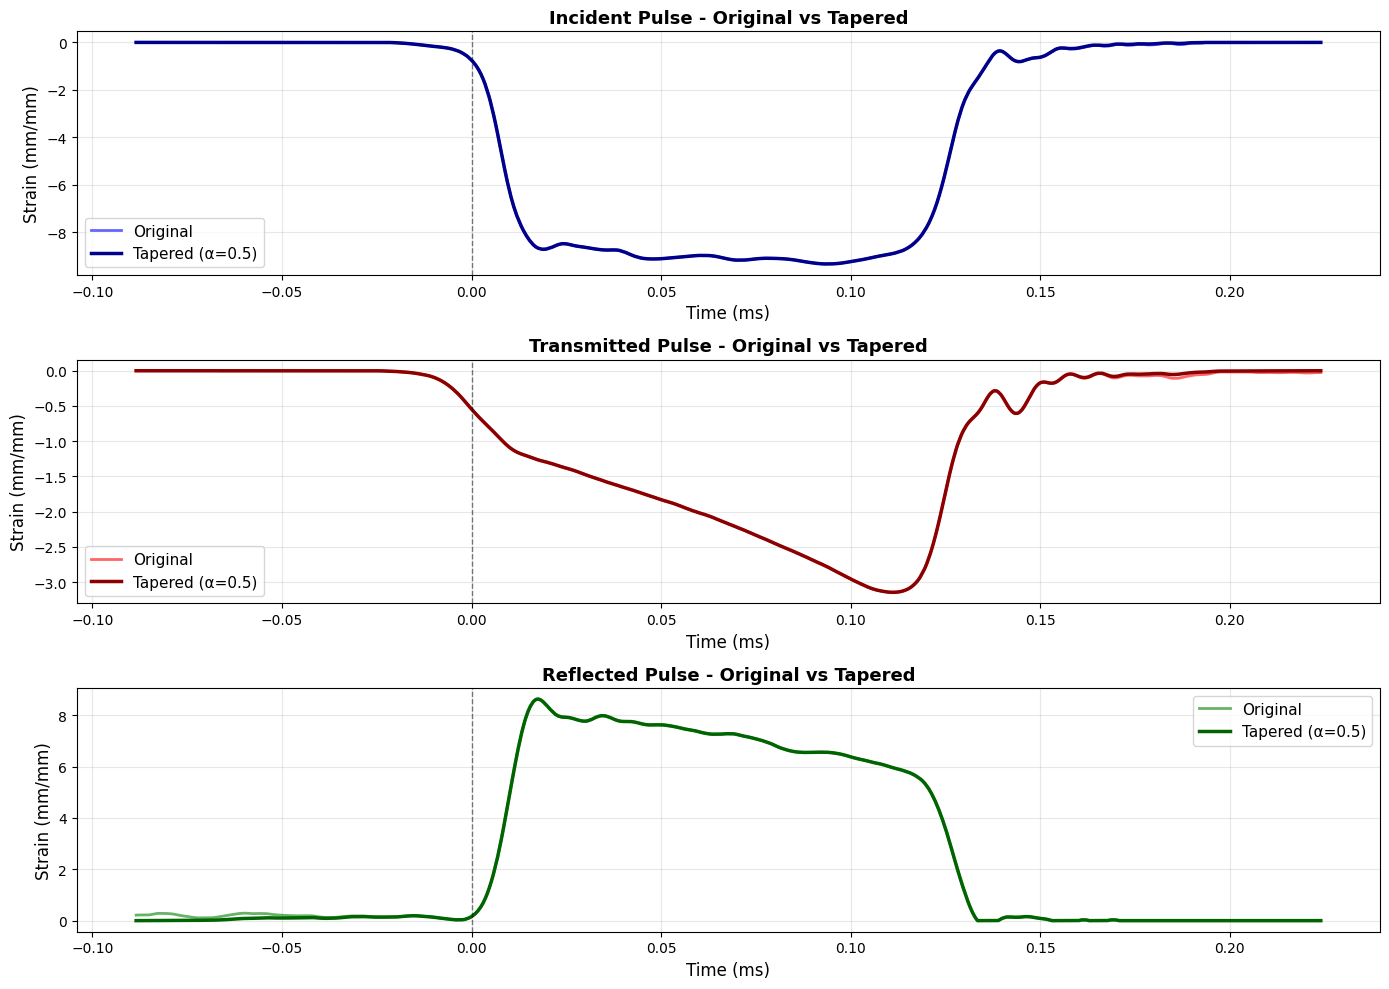

In [25]:
# Visualize effect of Tukey window on pulses
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Incident pulse
axes[0].plot(time_aligned, inc_aligned, lw=2.0, alpha=0.6, label='Original', color='blue')
axes[0].plot(time_aligned, inc_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkblue')
axes[0].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[0].set_xlabel('Time (ms)', fontsize=12)
axes[0].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[0].set_title('Incident Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Transmitted pulse
axes[1].plot(time_aligned, trs_aligned, lw=2.0, alpha=0.6, label='Original', color='red')
axes[1].plot(time_aligned, trs_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkred')
axes[1].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[1].set_title('Transmitted Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Reflected pulse
axes[2].plot(time_aligned, ref_aligned, lw=2.0, alpha=0.6, label='Original', color='green')
axes[2].plot(time_aligned, ref_tapered, lw=2.5, label='Tapered (α=0.5)', color='darkgreen')
axes[2].axvline(0, ls='--', c='k', lw=1, alpha=0.5)
axes[2].set_xlabel('Time (ms)', fontsize=12)
axes[2].set_ylabel('Strain (mm/mm)', fontsize=12)
axes[2].set_title('Reflected Pulse - Original vs Tapered', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()